<a href="https://colab.research.google.com/github/sdelta/Practical_DL/blob/spring21/homework03/diverging_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/celeba_data

identity_CelebA.txt   list_bbox_celeba.txt     list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_eval_partition.txt  list_landmarks_celeba.txt


In [3]:
!mkdir celeba
!cp drive/MyDrive/celeba_data/* celeba
!cp -R drive/MyDrive/CelebA/Img/img_align_celeba.zip ./celeba

In [4]:
!ls celeba

identity_CelebA.txt   list_eval_partition.txt
img_align_celeba.zip  list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_landmarks_celeba.txt
list_bbox_celeba.txt


In [5]:
!cd celeba && unzip -q img_align_celeba.zip && cd ..

In [6]:
!pip install pytorch-ignite


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 7.3 MB/s 


In [7]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")


torch: 1.12.1+cu113
torchvision: 0.13.1+cu113
ignite: 0.4.10


In [8]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist


In [9]:
ignite.utils.manual_seed(117)


In [10]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)


<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [11]:
from torchvision.datasets import ImageFolder

image_size = 64

data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = torchvision.datasets.CelebA(
    root='.',
    split='train',
    transform=data_transform
)
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(3000))


In [12]:
batch_size = 128

train_dataloader = idist.auto_dataloader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=2,
    pin_memory=True,
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=2,
    pin_memory=True,
    shuffle=False, 
    drop_last=True,
)


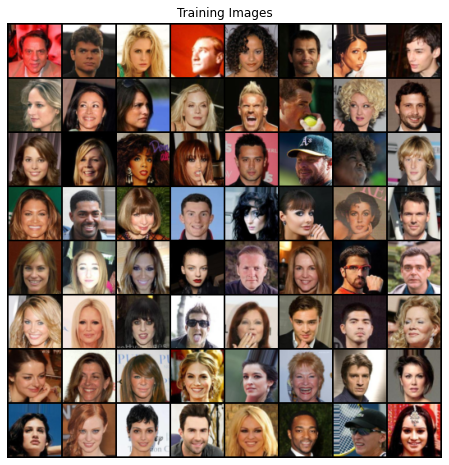

In [13]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [164]:
from copy import copy
from typing import List, Optional


class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)


class Noise(object):
    def __init__(self, shape:List[int], randomizer, idx:int):
        self.shape = shape
        self.randomizer = randomizer
        self.idx = idx

    def __call__(self):
        return self.randomizer._get_random(self.idx)


class AddScaledNoise(nn.Module):
    def __init__(self, shape:List[int], randomizer, idx:int):
        super(AddScaledNoise, self).__init__()
        self.shape = shape
        self.weight = nn.Parameter(torch.zeros(shape))
        self.randomizer = randomizer
        self.idx = idx

    def forward(self, input1):
        noise = self.randomizer._get_random(self.idx)
        assert list(input1.shape[1:]) == self.shape, "shape mismatch {} {}".format(input1.shape, self.shape)
        return input1 + self.weight.mul(noise)


class Randomizer(object):
    def __init__(self):
        self.register = []
        self.rnd = []

    def create_noise_layer(self, shape, subclass=None):
        layer = subclass(shape, self, len(self.register))
        self.register.append(layer)
        self.rnd.append(None)
        return layer

    def _get_random(self, idx):
        assert self.rnd[idx] is not None
        cur_rnd = self.rnd[idx]
        self.rnd[idx] = None
        return cur_rnd

    def set_rnd(self, rnd):
        self.rnd = copy(rnd)

    def generate_rnd(self, batch_size:int):
        result = []
        for layer in self.register:
            result.append(torch.randn([batch_size] + layer.shape, device=idist.device()))
        return result


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.randomizer = Randomizer()

        self.initial = self.randomizer.create_noise_layer([512, 4, 4], subclass=Noise)

        self.generator = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 256, 4, 2, 1,  bias=False),
            #self.randomizer.create_noise_layer([256, 8, 8], subclass=AddScaledNoise),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            #self.randomizer.create_noise_layer([128, 16, 16], subclass=AddScaledNoise),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),            

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            #self.randomizer.create_noise_layer([64, 32, 32], subclass=AddScaledNoise),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            #self.randomizer.create_noise_layer([32, 64, 64], subclass=AddScaledNoise),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 3, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(3),
            nn.Tanh()
        )

    def forward(self, rnd=None, batch_size:Optional[int]=None):
        if rnd is None:
            assert batch_size
            rnd = self.generate_rnd(batch_size)
        else:
            assert batch_size is None
        self.randomizer.set_rnd(rnd)
        return self.generator(self.initial())

    def generate_rnd(self, batch_size:int):
        return self.randomizer.generate_rnd(batch_size)

In [165]:
netG = idist.auto_model(Generator())


In [166]:
idist.device()


device(type='cuda')

In [167]:
#summary(netG)


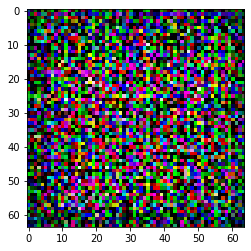

In [168]:
images = netG(batch_size=1)
images = images.squeeze().data.cpu().permute(1, 2, 0).numpy()
plt.imshow(images, interpolation="none")

In [169]:
class Discriminator3x64x64(nn.Module):
    def __init__(self):
        super(Discriminator3x64x64, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=0),
        )

    def forward(self, x):
        x = self.model(x)
        return x


In [170]:
netD = idist.auto_model(Discriminator3x64x64())
summary(netD, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
    InstanceNorm2d-2           [-1, 64, 32, 32]               0
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
    InstanceNorm2d-5          [-1, 128, 16, 16]               0
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
    InstanceNorm2d-8            [-1, 256, 8, 8]               0
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       1,180,160
   InstanceNorm2d-11            [-1, 512, 4, 4]               0
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,193
Total params: 1,559,169
Trainable param

In [171]:
fixed_noise = netG.generate_rnd(batch_size)


In [172]:
optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
)


In [173]:
def grad_penalty_loss(discriminator, real_data, fake_data, alpha=None):
    if alpha is None:
        alpha = torch.rand((real_data.size(0), 1, 1, 1), device=real_data.device)
    mixed_data = alpha * real_data + (1 - alpha) * fake_data
    mixed_data.requires_grad_(True)
    mixed_prediction = discriminator(mixed_data)
    grads = torch.autograd.grad(
        inputs=mixed_data, 
        outputs=mixed_prediction, 
        create_graph=True, 
        retain_graph=True,
        grad_outputs=torch.ones_like(mixed_prediction)
    )[0]
    grads = grads.view(real_data.size(0), -1)
    return torch.mean((torch.linalg.norm(grads, dim=1) - 1) ** 2)

In [174]:
def training_step(engine, data, lambda_gp=10):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    # Forward pass real batch through D
    # Calculate loss on all-real batch
    errD_real = -netD(real).mean()
    # Calculate gradients for D in backward pass

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = netG.generate_rnd(b_size)
    # Generate fake image batch with G
    fake = netG(noise)
    # Calculate D's loss on the all-fake batch
    errD_fake = netD(fake.detach()).mean()
    # calc gradient penalty
    gp = lambda_gp * grad_penalty_loss(netD, real, fake.detach())
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake + gp
    # Update D
    errD.backward()
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    # Since we just updated D, perform another forward pass of all-fake batch through D
    # Calculate G's loss based on this output
    errG = -netD(fake).mean()
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "gp_term": gp.item(),
    }

In [175]:
trainer = Engine(training_step)


In [176]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [177]:
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)


In [178]:
G_losses = []
D_losses = []

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])


In [179]:
img_list = []


@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)


In [180]:
from ignite.metrics import FID, InceptionScore


In [181]:
fid_metric = FID(device=idist.device())
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])


In [182]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        netG.eval()
        fake_batch = netG(batch_size=batch_size)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real


In [183]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")


In [184]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/10] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")


In [185]:
from ignite.metrics import RunningAverage


RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')


In [186]:
from ignite.contrib.handlers import ProgressBar


ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)


In [187]:
#def training(*args):
#    trainer.run(train_dataloader, max_epochs=10)

#with idist.Parallel(backend='nccl') as parallel:
#    parallel.run(training)

trainer.run(train_dataloader, max_epochs=10)

[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [1/10] Metric Scores
*   FID : 0.139254
*    IS : 1.268662


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [2/10] Metric Scores
*   FID : 0.142689
*    IS : 1.829809


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [3/10] Metric Scores
*   FID : 0.111638
*    IS : 1.861700


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [4/10] Metric Scores
*   FID : 0.172769
*    IS : 1.934771


[1/1271]   0%|           [00:00<?]

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

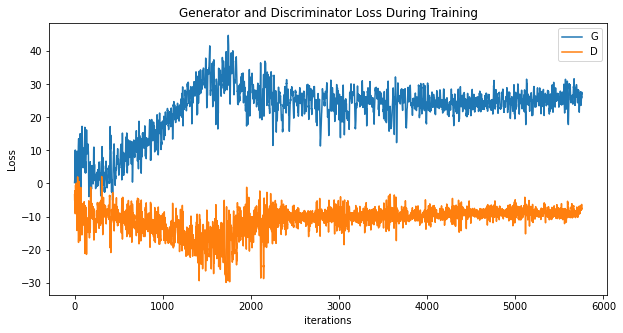

In [189]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[50:],label="G")
plt.plot(D_losses[50:],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()


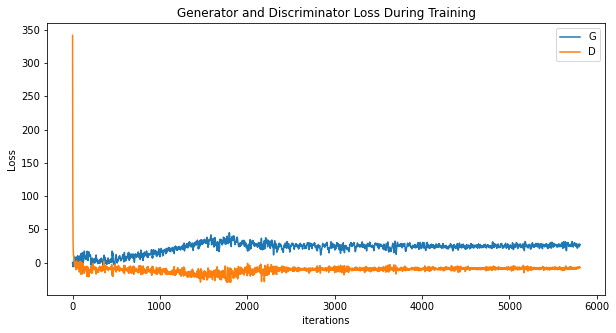

In [190]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()


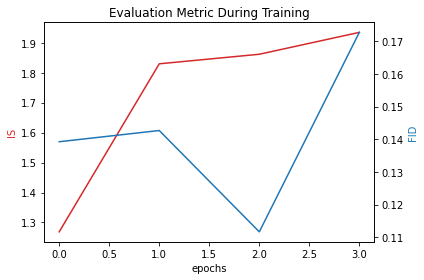

In [191]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()


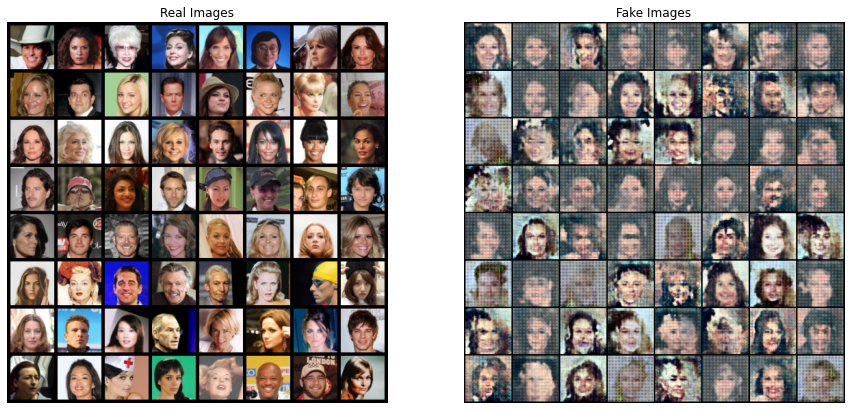

In [192]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1][:64], padding=2, normalize=True).cpu(),(1,2,0)))


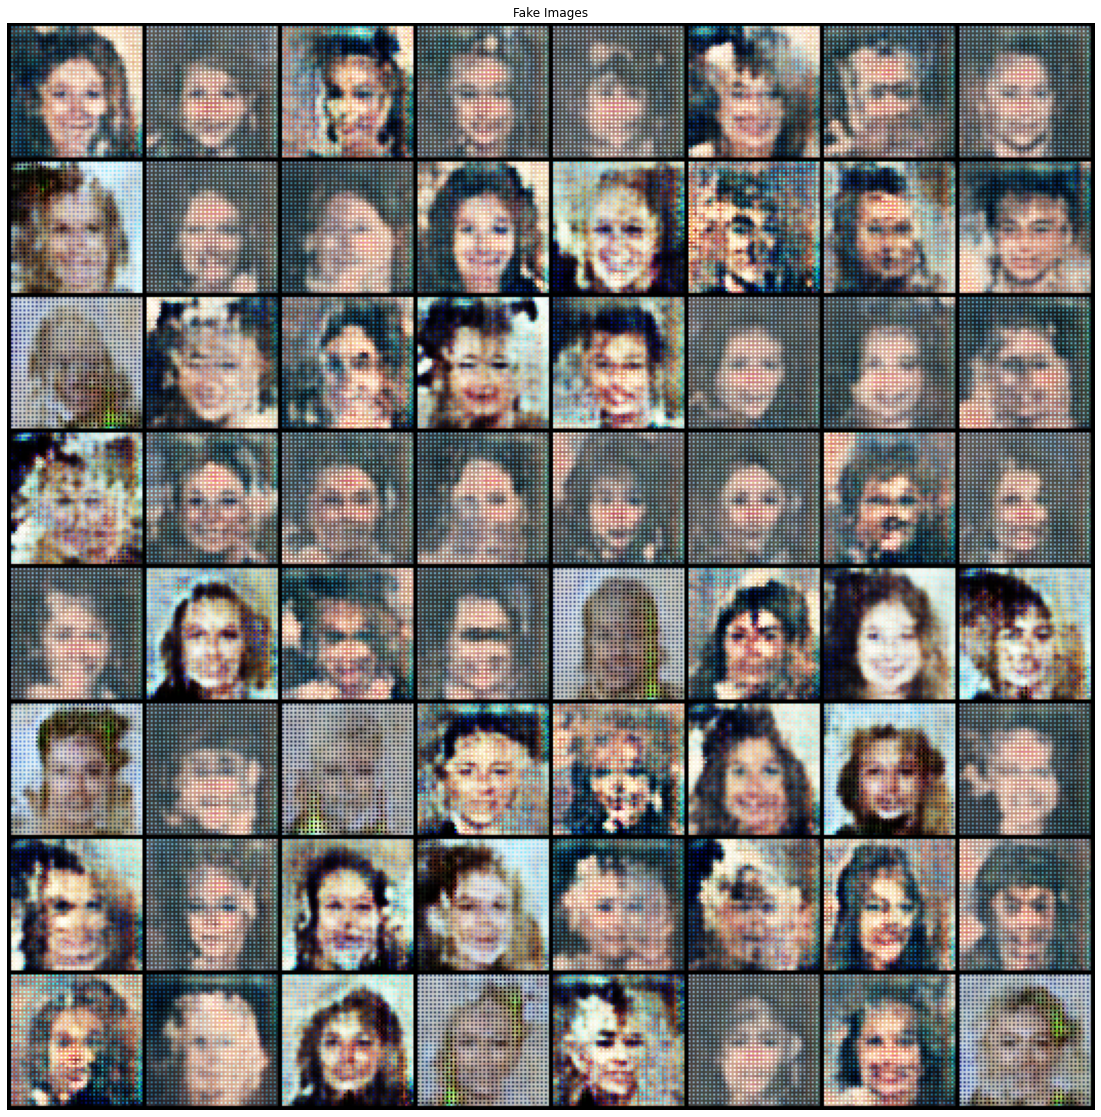

In [193]:


plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

## Conclusions

* normalization layers makes everything better
* Layer norm is worse than BatchNorm and InstanceNorm
* Final layers of D shouldn't be linear but convolutional
* There should be a lot of channels from the start
* Pay attention to layers with wgan-wp: they should have continious second derivative. Example of bad layer: ELU
* Bilinear upsample + conv after it is bad combo, it results in too much blur
* conv2dTranspose results into checkerboard artefacts


## Future work

### StyleGan-1
Link https://paperswithcode.com/method/stylegan

Features:
1. Separate noise for each scale
2. Preprocess noise by scaling before adding
3. AdaIN blocks
4. Add Style with dense net preprocessing
5. Style mixing - using two style latents


### Progressive Gan
Link https://paperswithcode.com/method/progan


### Miscelanous
* Residual blocks
* Dropout in D
* Train D on labels
* R1 regularization https://paperswithcode.com/method/r1-regularization
* BEGAN
* SAGAN
* Spectral normalization
